In [48]:
import pandas as pd
import numpy as np
import catboost as cbt
from sklearn.metrics import accuracy_score, roc_auc_score,log_loss
import gc
import math
import time
import datetime
from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from datetime import datetime,timedelta
import warnings
import seaborn as sns
import os
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from string import punctuation
from sklearn import svm
from sklearn.feature_extraction import stop_words

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
from nltk import ngrams
from itertools import chain
from wordcloud import WordCloud
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None
pd.options.display.max_rows = None
from matplotlib.font_manager import FontProperties

font = FontProperties(fname=r"c:\windows\fonts\simsun.ttc", size=14)

file_path = './Problem_C_Data/hair_dryer.tsv'
file_path2 = './Problem_C_Data/microwave.tsv'
file_path3 = './Problem_C_Data/pacifier.tsv'

reviews1 = pd.read_csv(file_path3, sep='\t', header=0)
mapping = {"N":"hair dryer","n":"microwave","Y":"pacifier"}
reviews1["product"]  = reviews1["vine"].map(mapping)

In [49]:
df.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,product,Star rating
0,US,40626522,R1A3ZUBR8TSAKY,B00793CZAE,572944212,"mary meyer wubbanub plush pacifier, lamb",Baby,5,0,0,N,Y,Love this!,Perfect match for the Gund Huggybuddy I bought...,8/31/2015,hair dryer,5
1,US,16290022,RLJNYBK4FGBYX,B003PCYMP4,911821018,wubbanub lamb infant pacifier,Baby,5,0,0,N,Y,Love 💕,My little girl love this paci contraption!,8/31/2015,hair dryer,5
2,US,10216509,R26QCW75C4JDOK,B003CK3LDI,392768822,wubbanub infant pacifier - giraffe,Baby,5,0,0,N,Y,Five Stars,My son loves this one and will only sleep if h...,8/31/2015,hair dryer,5
3,US,114040,R2E7N0TVLUHUDR,B003CK3LDI,392768822,wubbanub infant pacifier - giraffe,Baby,5,0,0,N,Y,Five Stars,Perfect,8/31/2015,hair dryer,5
4,US,27971579,R1SO9VMCIGZX3U,B003PCYMP4,911821018,wubbanub lamb infant pacifier,Baby,5,0,0,N,Y,Five Stars,Amazing addition to the nursery!,8/31/2015,hair dryer,5


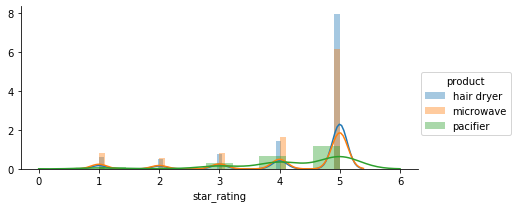

In [51]:
feature_name = ['star_rating']
for i in feature_name:
    sns.FacetGrid(data = reviews1, hue='product', aspect=4).map(sns.distplot, i).add_legend(); plt.show()

*** Rating distribution ***
5    12660
4     2716
3     1426
1     1192
2      945
Name: star_rating, dtype: int64


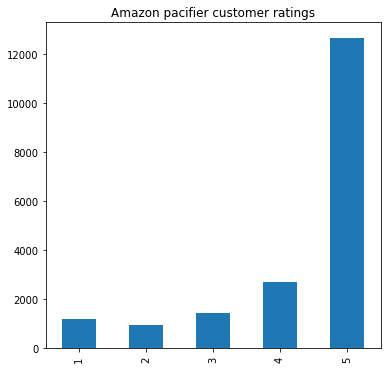

In [22]:
from matplotlib import pyplot
%matplotlib inline

star = reviews.star_rating.value_counts()
print("*** Rating distribution ***")
print(star)
star.sort_index(inplace=True)
star.plot(kind='bar',title='Amazon pacifier customer ratings',figsize=(6,6),style='Solarize_Light2')

In [23]:
title = reviews['product_title'].value_counts().index[0]

In [4]:
kindle = reviews[reviews.product_title==title]

 NPS score of Kindle is : 66.01


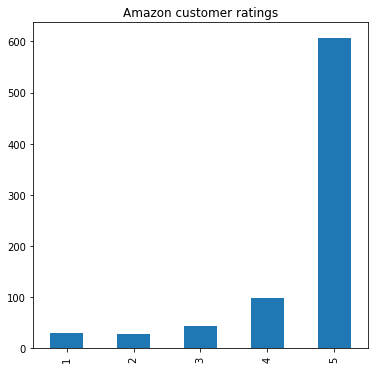

In [5]:
kindle_s = kindle.star_rating.value_counts()
kindle_s.sort_index(inplace=True)

Kindle_NPS_score = round (100*(kindle_s[5]-sum(kindle_s[1:3]))/sum(kindle_s),2)
print (" NPS score of Kindle is : "  + str(Kindle_NPS_score))
#better NPS than overall amazon
kindle_s.plot(kind='bar',title='Amazon customer ratings',figsize=(6,6),style='Solarize_Light2')

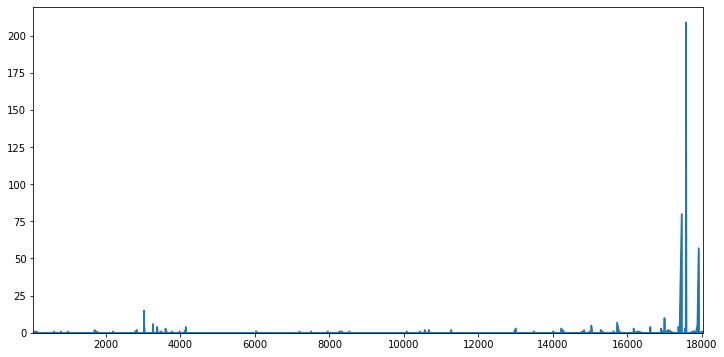

In [6]:
kindle['Helpful %'] = np.where(kindle['helpful_votes'] > 0, kindle['helpful_votes'] / kindle['total_votes'], -1)

kindle['temp'] = kindle.review_date.apply(lambda x : pd.to_datetime(x))
kindle_review_dates = kindle['helpful_votes']
kindle_review_dates.sort_index(inplace=True)
kindle_review_dates.plot(kind='area',figsize=(12,6))

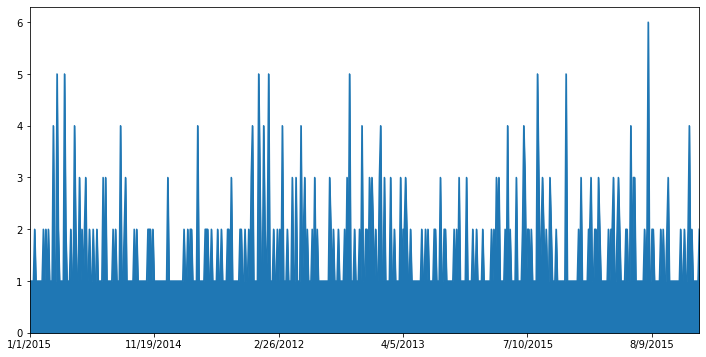

In [7]:
kindle['temp'] = kindle.review_date.apply(lambda x : pd.to_datetime(x))
kindle_review_dates = kindle.review_date.value_counts()
kindle_review_dates.sort_index(inplace=True)
kindle_review_dates.plot(kind='area',figsize=(12,6))

In [8]:
rating_perdate = kindle_review_dates.sort_values(ascending=False)
peakrating = rating_perdate[:20]
peak_month=[]
for x in peakrating.index:
    peak_month.append(pd.to_datetime(x).month)
pd.Series(peak_month).value_counts()

2     5
1     4
8     2
7     2
4     2
3     2
12    1
10    1
9     1
dtype: int64

Insight
* January month has the highest number of peaks >> Activity is high >> More Sales during Jan 
* There is high degree of variance in reviews added over time

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001481D1E2B00>]],
      dtype=object)

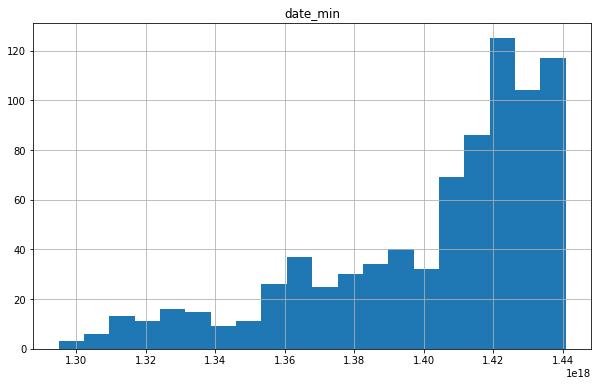

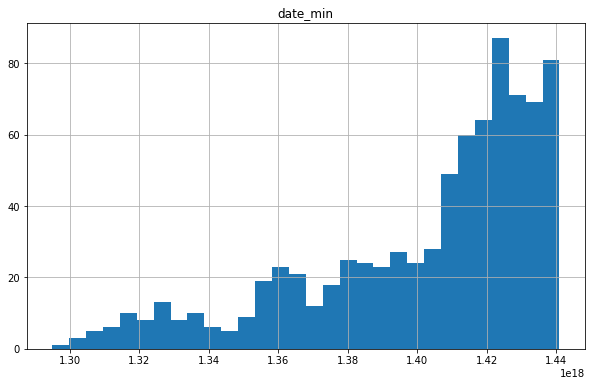

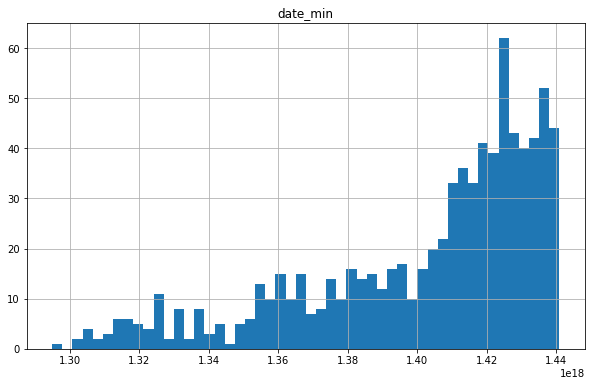

In [9]:
rating_series = pd.DataFrame(kindle.review_date)
dforms=[]
for x in rating_series.review_date:
    dforms.append((pd.to_datetime(x)).value)
# now we have dforms which has dates transformed to numeric values
rating2 = rating_series.assign(date_min = dforms)
rating2.reset_index(inplace=True)
#rating2.set_index('date_min')
#rating2.columns=['timestamp_string','review_count','date_min']
bins = np.linspace(min(rating2.date_min),max(rating2.date_min),num=50)
rating2.hist(column='date_min', bins=20,figsize=(10,6),)
rating2.hist(column='date_min', bins=30,figsize=(10,6))
rating2.hist(column='date_min', bins=50,figsize=(10,6))

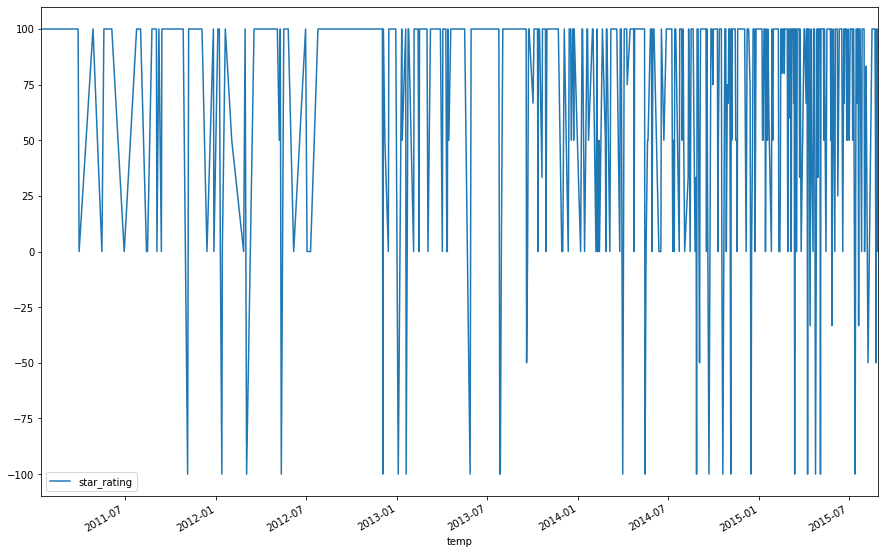

In [10]:
def NPS_eval (A):
    score =0
    for x in A[:]:
        if (x>4) :
            score+=1
        elif (x<3) :
            score-=1
    return 100*score/len(A)    
NPS_overtime = kindle[['temp','star_rating']]
NPS_overtime.groupby(by='temp').agg(NPS_eval).plot(figsize=(15,10))

AxesSubplot(0.125,0.125;0.775x0.755)


,star_rating
timeline,
37,37.500000
50,40.000000
24,40.000000
15,50.000000
30,50.000000
18,50.000000
26,50.000000
25,50.000000
68,52.631579


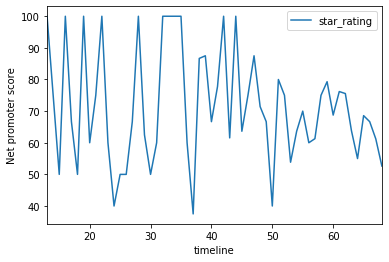

In [20]:
NPS_overtime['timeline']= NPS_overtime['temp'].apply(lambda x : (x.month+(12*(x.year-2010))))
NPS_by_month= NPS_overtime.groupby(by='timeline').agg(NPS_eval)
print(NPS_by_month.plot())
plt.ylabel('Net promoter score')
NPS_by_month.sort_values(by='star_rating')